DATA: https://www.kaggle.com/datasets/emmanuelfwerr/london-homes-energy-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

**READ DATASET**

In [2]:
# Read dataset
df = pd.read_csv('/kaggle/input/london-homes-energy-data/london_energy.csv')
print(df.isna().sum())
df.head()

LCLid    0
Date     0
KWH      0
dtype: int64


,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


**PREPROCESSING DATASET**

In [3]:
# We group the data by "Date"
df_average = df.groupby("Date")["KWH"].mean()
df_average = pd.DataFrame({
    'date': df_average.index.tolist(),
    'consumption': df_average.values.tolist()
})
df_average["date"] = pd.to_datetime(df_average["date"])

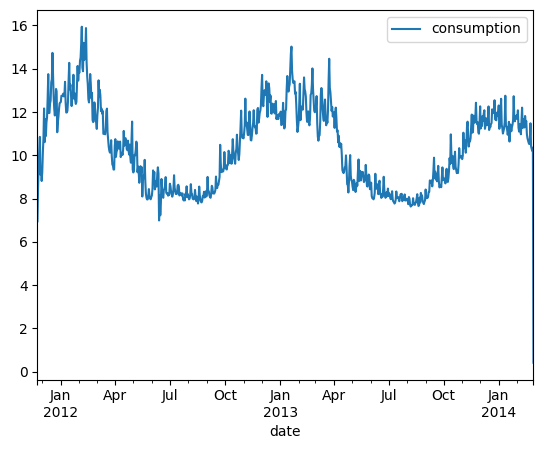

In [4]:
# Plot the data
df_average.plot(x = 'date', y = 'consumption');

In [5]:
df_average["day_of_week"] = df_average["date"].dt.dayofweek
df_average["day_of_year"] = df_average["date"].dt.dayofyear
df_average["month"] = df_average["date"].dt.month
df_average["quarter"] = df_average["date"].dt.quarter
df_average["year"] = df_average["date"].dt.year

df_average.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011


In [6]:
# Split the dataset
training_mask = df_average['date'] <= '2013-07-28'
training_data = df_average.loc[training_mask]

testing_mask = df_average['date'] > '2013-07-28'
testing_data = df_average.loc[testing_mask]

In [7]:
print(f'Training data shape: {training_data.shape}')
print(f'Testing data shape: {testing_data.shape}')

Training data shape: (614, 7)
Testing data shape: (215, 7)


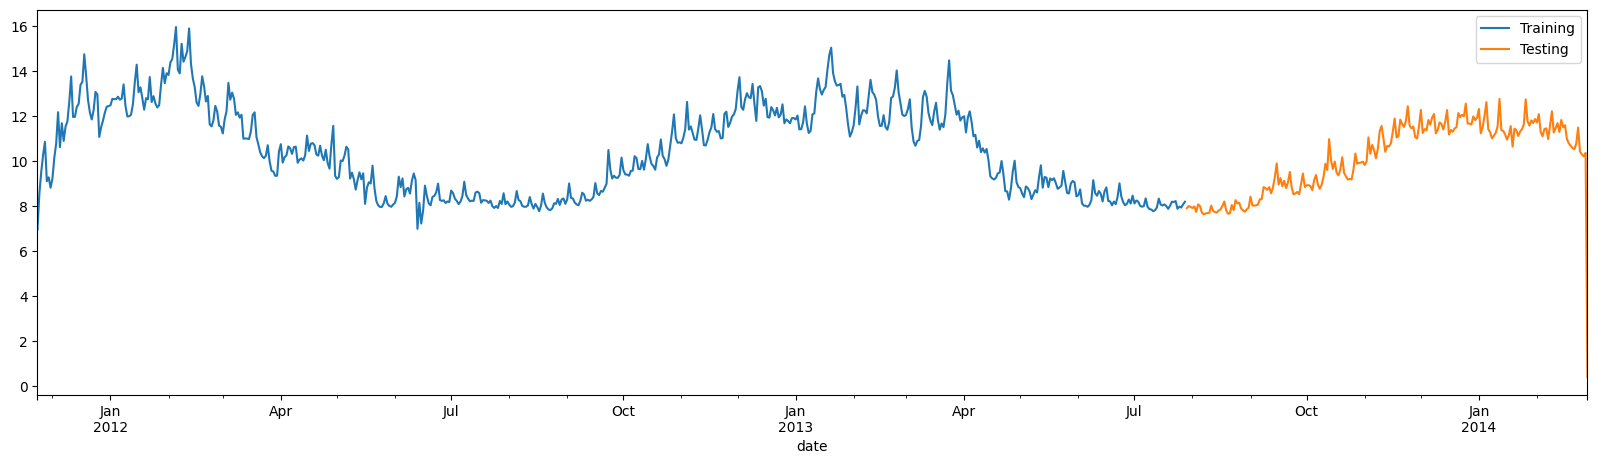

In [8]:
# Traing and testing data
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [9]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

**MODEL**

In [54]:
# We use XGboost to forecast
cv_split = TimeSeriesSplit(n_splits = 4, test_size = 100)
model = XGBRegressor()
parameters = {
    'max_depth': [3,4,5,6],
    'learning_rate': [1e-2, 9e-2],
    'n_estimators': [100, 300, 500],
    'colsample_bytree': [0.3]
}

grid_search = GridSearchCV(estimator = model, cv = cv_split, param_grid = parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3],
                         'learning_rate': [0.01, 0.09],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 300, 500]})

In [55]:
# Evaluate the model
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

In [56]:
# Plot the predictions
def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

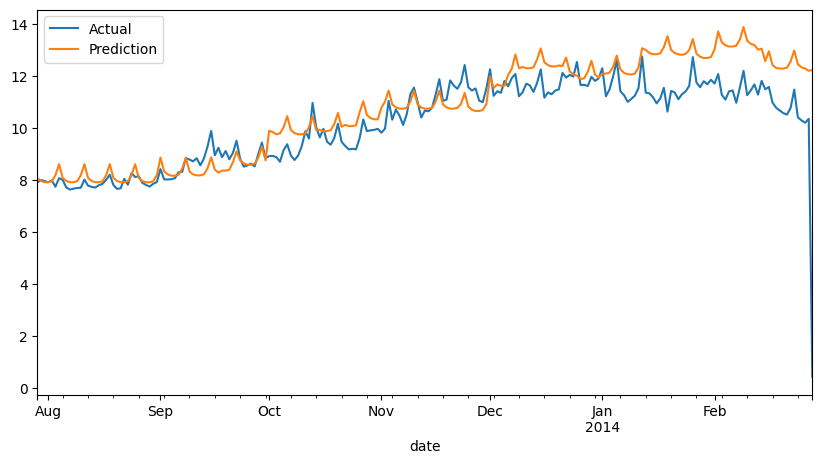

MAE: 0.7665073416903276
MSE: 1.4989156720769317
MAPE: 0.19893243013689718


In [57]:
# GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)